# Exploring Single Neuron Excitability with Mathematical and Computational Models Computer lab 2
## Brian2 and Model Fitting
##### Nils Koch and Niklas Brake

Example of Izhekevich model implmentation in Brian 2 and exploration of model fitting


# 1. Brain2


## Izhekevich model implemented in brian2


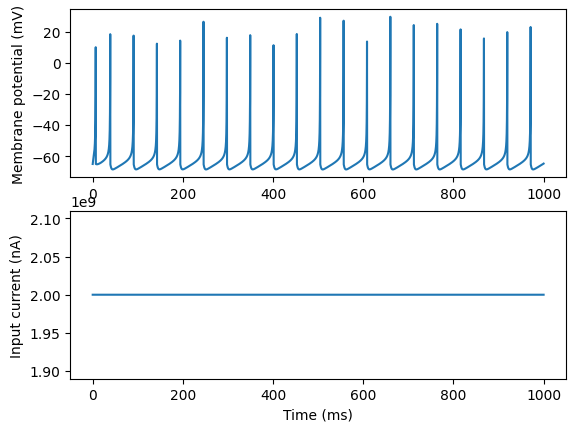

In [1]:
import brian2
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import brian2
from brian2 import NeuronGroup, Synapses, SpikeMonitor, StateMonitor
from brian2 import ms, mV, nA
from brian2 import defaultclock, run

brian2.start_scope()
# Define the Izhekevich model equations
eqs = """dv/dt = (0.04*v**2 + 5*v + 140 - u + I )/ms : 1
         du/dt = (a*(b*v - u))/ms  : 1
         I : 1
         a : 1
         b : 1
         c : 1
         d : 1
       """

# Create a neuron group with a single neuron using the model and parameters
neuron = NeuronGroup(1, eqs, threshold="v>=30", reset="v=c; u+=d", method="euler")

# Set the parameters for the model
neuron.a = 0.02
neuron.b = 0.25
neuron.c = -65
neuron.d = 2

# Define the initial conditions for the model
v0 = -70 * mV
u0 = neuron.b * v0/ms

# Set the initial values for the neuron's membrane potential and recovery variable
neuron.v = -65
neuron.u = "b*v"

# Set the input current for the neuron
input_current = 2 # nA
neuron.I = input_current

# Create a monitor to record the neuron's membrane potential and input current
monitors = StateMonitor(neuron, ['v', 'I'], record=True)

# Run the simulation for 100 milliseconds
dur = 1000 * ms
run(dur)

# Plot the neuron's membrane potential and input current over time
plt.figure()
plt.subplot(211)
plt.plot(monitors.t/ms, monitors.v[0])
plt.ylabel('Membrane potential (mV)')
plt.subplot(212)
plt.plot(monitors.t/ms, monitors.I[0]/nA)
plt.ylabel('Input current (nA)')
plt.xlabel('Time (ms)')
plt.show()


# 2. The Fitting Problem

Let's fit an Izhekevich model to the spiking from Hodgkin Huxley model.

This is the Hodgkin Huxley model implemented in Brian2 and the resulting spike train we will try to fit

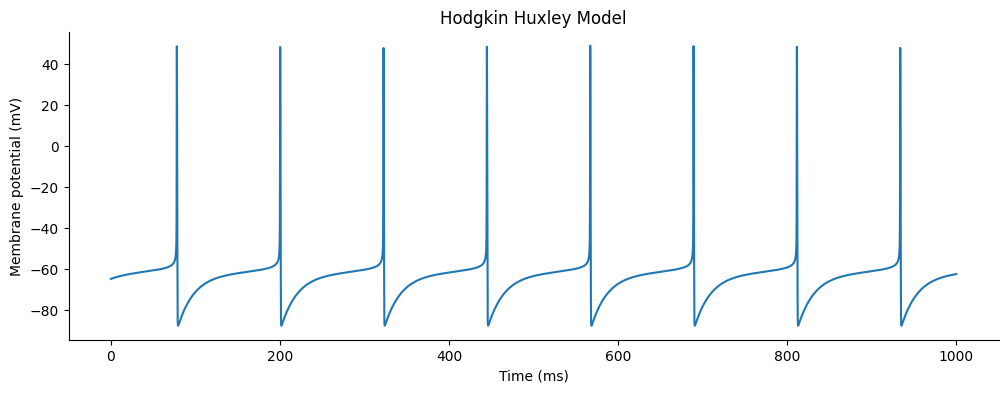

In [2]:
from brian2 import *
brian2.start_scope()

# Parameters
area = 1*cm**2
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV
taue = 5*ms
taui = 10*ms

# The model
HH_eqs = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I )/Cm: volt
dm/dt = 0.32*(mV**-1)*4*mV/exprel((13.*mV-v+VT)/(4*mV))/ms*(1-m)-0.28*(mV**-1)*5*mV/exprel((v-VT-40.*mV)/(5*mV))/ms*m : 1
dn/dt = 0.032*(mV**-1)*5*mV/exprel((15.*mV-v+VT)/(5*mV))/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1
I : amp
''')

# Threshold and refractoriness are only used for spike counting
HH_neuron = NeuronGroup(10, HH_eqs, threshold='v > -40*mV', refractory='v > -40*mV', method='exponential_euler')
HH_neuron.v = El
HH_neuron.I = 150.*nA #100. *nA #'0.7*nA * i / num_neurons'

# HH = Network(HH_neuron)
HH_monitor = StateMonitor(HH_neuron, ['v'], record=True, dt=0.1*ms)

duration = 1000 * ms #0.2*second
run(duration)

t_obs = HH_monitor.t/ms
y_obs = HH_monitor.v[0]/mV
# plot the result
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(t_obs, y_obs)
ax.set_title('Hodgkin Huxley Model')
ax.set_ylabel('Membrane potential (mV)')
ax.set_xlabel('Time (ms)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

Feature extraction for Hodgkin Huxley Neuron

In [3]:
import efel
efel_feat = efel.getFeatureNames()

efel_feat = ['AP_amplitude','AP_duration','AP_height', 'AP_width', 'ISI_CV', 'ISI_values', 'Spikecount', 'Spikecount_stimint',
 'adaptation_index', 'adaptation_index2', 'irregularity_index', 'mean_frequency',  'spike_half_width','spike_width2', 'peak_indices','all_ISI_values']

trace1 = {}
trace1['T'] = HH_monitor.t/ms
trace1['V'] = HH_monitor.v[0]/mV
trace1['stim_start'] = [0.]
trace1['stim_end'] = [1000.]

# Multiple traces can be passed to the eFEL at the same time, so the argument should be a list
HH_traces = [trace1]

# feature extraction settings
efel.api.setThreshold(-20)  # set spike detection threshold
efel.setDoubleSetting('interp_step', 0.1)  # set interpolation step to sampling rate or simulation step size
efel.setIntSetting('ignore_first_ISI', 0)

# extract features
HH_traces_results = efel.getFeatureValues(HH_traces, efel_feat, raise_warnings=False)
print(HH_traces_results)

[{'AP_amplitude': array([99.22443837, 97.87642311, 97.5180763 , 98.37240577, 99.21972078,
       99.26247543, 97.93708458, 97.55161837]), 'AP_duration': array([2. , 1.9, 1.9, 1.9, 1.9, 2. , 1.9, 1.9]), 'AP_height': array([48.45759655, 48.1265056 , 47.62641783, 48.25978306, 48.7456185 ,
       48.5202059 , 48.21502848, 47.69653686]), 'AP_width': array([0.7, 0.7, 0.6, 0.7, 0.7, 0.7, 0.7, 0.7]), 'ISI_CV': array([0.00030926]), 'ISI_values': array([122.2, 122.3, 122.2, 122.2, 122.2, 122.2, 122.2]), 'Spikecount': array([8]), 'Spikecount_stimint': array([8]), 'adaptation_index': array([-8.1799591e-05]), 'adaptation_index2': array([-8.1799591e-05]), 'irregularity_index': array([0.02857143]), 'mean_frequency': array([8.56898029]), 'spike_half_width': array([0.68779272, 0.6864176 , 0.68458287, 0.68880225, 0.69237072,
       0.68819993, 0.68669994, 0.68549026]), 'spike_width2': array([0.48865402, 0.43965726, 0.44761643, 0.4671525 , 0.48181828,
       0.48742069, 0.43740956]), 'peak_indices': arra

### Genetic Algorithm Fitting with PyGAD



Define a fitness function for the error between timeseries

In [7]:
brian2.start_scope()
neuron = NeuronGroup(1, eqs, threshold="v>=30", reset="v=c; u+=d", method="euler")

def calculate_fitness(solution, y_obs):
    a1, b1, c1, d1 = solution

    neuron.a = a1
    neuron.b = b1
    neuron.c = c1
    neuron.d = d1
    v0 = -70 * mV
    u0 = neuron.b * v0/ms
    neuron.v = -65
    neuron.u = "b*v"
    input_current = 2 # nA
    neuron.I = input_current
    monitors = StateMonitor(neuron, ['v'], record=True, dt=0.1*ms)
    dur = 1000 * ms
    run(dur)
    y_pred = monitors.v[0]
    mse = np.mean((y_pred - y_obs) ** 2)
    return 1 / mse

# Define the fitness function
def fitness_func(solution, solution_idx):
    return calculate_fitness(solution, y_obs)

Setup genetic algorithm and options

In [8]:
import pygad
# Define the bounds for the parameter values
# param_bounds = np.array([[0, 1], [0, 1], [0, 10]]) # param 1 can be 0 or 1
# use dictionary for continuous values i.e. in range [low, high) i
gene_space = [{'low': 0., 'high': 2.}, {'low': 0., 'high': 1.},{'low': -70., 'high': -20.}, {'low': 0., 'high': 10}]

# Create the genetic algorithm object
# all parameters for pygad.GA found here https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html
ga = pygad.GA(initial_population=None,  #if None, do not set explicit init_pop but let pyGAD initialize
              sol_per_pop=100,  # number of individuals
              num_genes=4,  # number of genes
              fitness_func=fitness_func,
              num_generations=100,
              num_parents_mating=10,
              gene_type=float,
              mutation_num_genes=2,
              gene_space=gene_space,  # bounds on parameters
              # parallel_processing=5
              )

Run genetic algorithm and plot fitness over generations

In [9]:
ga.run()
solution, solution_fitness, _ = ga.best_solution() # Get the best solution
print("Best solution: ", solution)
ga.plot_fitness()

KeyboardInterrupt: 

Plot best solution and compare to y_obs

In [ ]:
neuron.a = solution[0]
neuron.b = solution[1]
neuron.c = solution[2]
neuron.d = solution[3]
v0 = -70 * mV
u0 = neuron.b * v0/ms
neuron.v = -65
neuron.u = "b*v"
input_current = 2 # nA
neuron.I = input_current
monitors = StateMonitor(neuron, ['v'], record=True)
dur = 1000 * ms
run(dur)
fig, ax = plt.subplots()
ax.plot(t/1000, y_obs, label='data', color='tab:blue')
ax.plot(monitors.t/ms, monitors.v[0], label='GA fit', color='tab:orange')
plt.show()

### What if we fit based on electrophysiological features instead of voltage trace?

Define a new fitness function

In [ ]:
def calculate_fitness_feature(solution, y_obs):
    a1, b1, c1, d1 = solution

    neuron.a = a1
    neuron.b = b1
    neuron.c = c1
    neuron.d = d1
    v0 = -70 * mV
    u0 = neuron.b * v0/ms
    neuron.v = -65
    neuron.u = "b*v"
    input_current = 2 # nA
    neuron.I = input_current
    monitors = StateMonitor(neuron, ['v'], record=True)
    dur = 1000 * ms
    run(dur)
    y_pred = monitors.v[0]



    mse = np.mean((y_pred_features - y_obs_features) ** 2)
    return 1 / mse

# Define the fitness function
def fitness_func_features(solution, solution_idx):
    return calculate_fitness_features(solution, y_obs)

Setup new genetic algorithm and options with new fitness function

In [ ]:
ga_features = pygad.GA(initial_population=None,  #if None, do not set explicit init_pop but let pyGAD initialize
              sol_per_pop=100,  # number of individuals
              num_genes=4,  # number of genes
              fitness_func=fitness_func_features,
              num_generations=100,
              num_parents_mating=10,
              gene_type=float,
              mutation_num_genes=2,
              gene_space=gene_space,  # same bounds on parameters as before
              # parallel_processing=5
              )

Run this genetic algorithm and plot fitness over generations

In [ ]:
ga_features.run()
solution_features, solution_fitness_features, _ = ga_features.best_solution()  # Get the best solution
print("Best solution: ", solution_features)
ga_features.plot_fitness()

Plot best solution for fit on features and compare to y_obs

In [ ]:
neuron.a = solution_features[0]
neuron.b = solution_features[1]
neuron.c = solution_features[2]
neuron.d = solution_features[3]
v0 = -70 * mV
u0 = neuron.b * v0 / ms
neuron.v = -65
neuron.u = "b*v"
input_current = 2  # nA
neuron.I = input_current
monitors = StateMonitor(neuron, ['v'], record=True)
dur = 1000 * ms
run(dur)
fig, ax = plt.subplots()
ax.plot(t / 1000, y_obs, label='data', color='tab:blue')
ax.plot(monitors.t / ms, monitors.v[0], label='GA fit on features', color='tab:green')

In [ ]:
# import matplotlib.pyplot as plt
# import brian2
# from brian2 import NeuronGroup, Synapses, SpikeMonitor, StateMonitor
# from brian2 import ms, mV, nA
# from brian2 import defaultclock, run
#
# brian2.start_scope()
# # Define the Izhekevich model equations
# eqs = """dv/dt = (0.04*v**2 + 5*v + 140 - u + I )/ms : 1
#          du/dt = (a*(b*v - u))/ms  : 1
#          I : 1
#          a : 1
#          b : 1
#          c : 1
#          d : 1
#        """
#
#
# import numpy as np
# neuron = NeuronGroup(1, eqs, threshold="v>=30", reset="v=c; u+=d", method="euler")
#
#
#
# # Define the bounds for the parameter values
# # param_bounds = np.array([[0, 1], [0, 1], [0, 10]]) # param 1 can be 0 or 1
# # use dictionary for continuous values i.e. in range [low, high) i
# gene_space = [{'low': 0., 'high': 2.}, {'low': 0., 'high': 1.},{'low': -70., 'high': -20.}, {'low': 0., 'high': 10}]
#
# # Create the genetic algorithm object
# # all parameters for pygad.GA found here https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html
# ga = pygad.GA(initial_population=None,  #if None, do not set explicit init_pop but let pyGAD initialize
#               sol_per_pop=100,  # number of individuals
#               num_genes=4,  # number of genes
#               fitness_func=fitness_func,
#               num_generations=100,
#               num_parents_mating=10,
#               gene_type=float,
#               mutation_num_genes=2,
#               gene_space=gene_space,  # bounds on parameters
#               # parallel_processing=5
#               )
#
#
# ga.run()
# solution, solution_fitness, _ = ga.best_solution() # Get the best solution
# print("Best solution: ", solution)
# ga.plot_fitness()

# 3. Try fitting parameters to capture data

# Extra: Network of Izhekevich models

Create a network of spiking neurons
Adapted from https://brian2.readthedocs.io/en/stable/examples/frompapers.Izhikevich_2003.html based on http://izhikevich.org/publications/spikes.htm

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import brian2
# from brian2 import NeuronGroup, Synapses, SpikeMonitor, StateMonitor
# from brian2 import ms, mV
# from brian2 import defaultclock, run
brian2.start_scope()
tfinal = 1000 * ms
Ne = 800
Ni = 200

re = np.random.uniform(size=Ne)
ri = np.random.uniform(size=Ni)
weights = np.hstack(
    [
        0.5 * np.random.uniform(size=(Ne + Ni, Ne)),
        -np.random.uniform(size=(Ne + Ni, Ni)),
    ]
).T

defaultclock.dt = 1 * ms

eqs = """dv/dt = (0.04*v**2 + 5*v + 140 - u + I + I_noise )/ms : 1
         du/dt = (a*(b*v - u))/ms  : 1
         I : 1
         I_noise : 1
         a : 1
         b : 1
         c : 1
         d : 1
       """

N = NeuronGroup(Ne + Ni, eqs, threshold="v>=30", reset="v=c; u+=d", method="euler")
N.v = -65

N_exc = N[:Ne]
N_inh = N[Ne:]

spikemon = SpikeMonitor(N)
statemon = StateMonitor(N, 'v', record=0, when='after_thresholds')
N_exc.a = 0.02
N_exc.b = 0.2
N_exc.c = -65 + 15 * re**2
N_exc.d = 8 - 6 * re**2

N_inh.a = 0.02 + 0.08 * ri
N_inh.b = 0.25 - 0.05 * ri
N_inh.c = -65
N_inh.d = 2

N_exc.u = "b*v"
N_inh.u = "b*v"

S = Synapses(
    N,
    N,
    "w : 1",
    on_pre={"up": "I += w", "down": "I -= w"},
    delay={"up": 0 * ms, "down": 1 * ms},
)
S.connect()
S.w[:] = weights.flatten()


# Run abstract code in the group’s namespace.
# The created CodeRunner object will be automatically added to the group, it therefore does not need to be added to the network manually. However, a reference to the object will be returned, which can be used to later remove it from the group or to set it to inactive.
N_exc.run_regularly("I_noise = 5*randn()", dt=1 * ms)
N_inh.run_regularly("I_noise = 2*randn()", dt=1 * ms)

run(tfinal)

fig, (ax, ax_voltage) = plt.subplots(2, 1, sharex=True,
                                     gridspec_kw={'height_ratios': (3, 1)})

ax.scatter(spikemon.t / ms, spikemon.i[:], marker="_", color="k", s=10)
ax.set_xlim(0, tfinal / ms)
ax.set_ylim(0, len(N))
ax.set_ylabel("neuron number")
ax.set_yticks(np.arange(0, len(N), 100))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axhline(Ne, color="k")
ax.text(500, 900, 'inhibitory', backgroundcolor='w', color='k', ha='center')
ax.text(500, 400, 'excitatory', backgroundcolor='w', color='k', ha='center')

ax_voltage.plot(statemon.t / ms, np.clip(statemon.v[0], -np.inf, 30),
               color='k')
ax_voltage.text(25, 0, 'v₁(t)')
ax_voltage.set_xticks(np.arange(0, tfinal / ms, 100))
ax_voltage.spines['right'].set_visible(False)
ax_voltage.spines['top'].set_visible(False)
ax_voltage.set_xlabel("time, ms")

plt.show()